## Chapter 6, ML Engineering
##### Author: Ben Wilson

In this notebook, we'll be following along with the code listings shown in Chapter 6 of ML Engineering. 
In the notebook of chapter 5, we were doing some preparatory work for initiating a prototyping and testing phase for different approaches. We were building visualizations, tuning aids, and functional wrappers around code that we will be using for this prototype phase. 

### Listing 6.1 Exponential Smoothing function to generate a comparison forecast
Sticking with our mandate from Chapter 2, approaching a problem with the simplest methodology possible before trying more complex tasks, we're going to build a very simple exponential smoothing function. While this function won't do <i><u>forecasting per se</u></i>, it will certainly give us an indication of what a very simple approach would be like for a solution that could be extended to perform a basic regressive forecasting using nothing but the priors trend and very basic arithmetic.
> This will effectively be the baseline to measure all other tests against. If, in the process of trying out different approaches, we can't get better than this very simple implementation, then we should abandon that approach completely in the interests of more promising solutions.

> NOTE: the code listings in the book have the import statements embedded above each section. Don't do this in your scripts or notebooks (and certainly not in modules!). I have removed these import statements from those sections and placed them where they belong - at the first execution cell in this notebook.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pylab as plt
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 
from dateutil.parser import parse
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Define the required elements from Chapter 5 notebook in order to run the rest of this notebook...
DATA_PATH = '/opt/notebooks/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'
AIRPORT_FIELD = 'Airport Code'

def apply_index_freq(data, freq):
    return data.asfreq(freq)

def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

def get_airport_data(airport, file_location): 
    all_data = pull_raw_airport_data(file_location)
    filtered = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered

In [3]:
""" Function for fitting an exponential smoothing trend to time series data
:param raw_series: a numpy date indexed series with no missing date values
:param alpha: (default 0.05) the smoothing factor (range 0:1) to define the weighting 
   of prior values to current value's point (lower is smoother)
"""
def exp_smoothing(raw_series, alpha=0.05): 
    output = [raw_series[0]]
    for i in range(1, len(raw_series)):
        output.append(raw_series[i] * alpha + (1-alpha) * output[i-1])
    return output

### Listing 6.2 Mean Absolute Error and uncertainty
In this listing we're going to provide a mean absolute error(MAE) calculation between two series through using the MAE calculation in scikit-learn, then calculate a configurable stddev factor for error bars around the residuals.
This is to support the plotting efforts in listing 6.3, but will also be useful for further stages of the prototyping phase of the project.

In [4]:
from sklearn.metrics import mean_absolute_error

""" Function for calculating mae through scikit-learn and build stddev error series
:param raw_series: the raw data series, date indexed
:param smoothed_series: the exponentially smoothed series with identical index to raw_series
:param window: the size of the smoothing window
:param scale: percentile value of the standard normal distribution expressed in terms of stddev value
"""
def calculate_mae(raw_series, smoothed_series, window, scale):
    # dictionary to store the resulting values of the function's logic
    res = {}
    
    # why reinvent the wheel? Use common open source packages whenever possible (it will minimize bugs)
    mae_value = mean_absolute_error(raw_series[window:], smoothed_series[window:])
    
    # store the mae value in the dictionary
    res['mae'] = mae_value
    
    # calculate the stddev between the raw data and the smoothed data, filtering out the incomplete lagged
    #   exponential smoothing data (remember, we're smoothing over a window here so the elements of
    #   the smoothed series that couldn't calculate based on an incomplete window will be null)
    deviation = np.std(raw_series[window:] - smoothed_series[window:])
    
    # store the stddev data in the dictionary
    res['stddev'] = deviation
    
    # calculate the scaled stddev (e.g. with a scale of '2', we're calculating 2-sigma around the smoothed value)
    yhat = mae_value + scale * deviation
    
    # store the offset values of stddev as two separate series for plotting
    res['yhat_low'] = smoothed_series - yhat
    res['yhat_high'] = smoothed_series + yhat
    return res

We'll be using this in Listing 6.3 to make our plots in Listing 6.4. 

### Listing 6.3 Function for generating exponential smoothing and moving average data and visualizations
Here we're going to be adding in both listing 6.1 and 6.2 to build our 'baseline implementation' for comparison against all of the other tests we're going to be running during the prototype / exploration phase.
> It's not sufficient to simply look at metrics here. The reason we're taking the time to record both the metrics associated with this approach AND the visualization to go along with it (as well as making it into reusable code by wrapping it in a function) is so that each team will have the visual and statistical cues to compare their results against. The chances that this approach will be used in the final solution is VERY SLIM, but it's important to put a little bit of effort in building these early on in a project so that we can have these references available at any time, and in any of the subteams working on the bake-off. The level of standardization that this brings (everyone looking at the same formatted plots, using the same referenceable code, and having a common language to discuss the benefits of one approach over another <u><b>simply cannot be understated</b></u>.
>> NOTE: the lines within the function have been expanded with a space inbetween only to aid in reading the comments and the code. In 'actual, non-example code', there should be no such spaces in Python.

In [5]:
""" Function for generating the reference exponential smoothing plot for reference
:param time_series: the date indexed time series 
:param time_series_name: name of the time series (for plot labeling)
:param image_name: name of the file to save the image as in .svg format
:param smoothing_window: the size of the smoothing window to lag over for exponential smoothing (a bigger window
  results in a lower rate of change over time)
:param exp_alpha: smoothing factor (scale 0:1) to define weighting of prior window values on the curve 
    (higher is less smooth, taking more weight for more recent values in the window)
:param yhat_scale: (default 1.96, representing 97.5% of the standard normal distribution) 
    factor corresponding to the percentile value fo the standard normal distribution expressed in terms of stddev
:param style: matplotlib.pyplot style type for the plots. defaulted as seaborn style.
:param plot_size: the size of the entire figure being generated in inches.
"""
def smoothed_time_plots(time_series, time_series_name, image_name, smoothing_window, exp_alpha=0.05, 
                        yhat_scale=1.96, style='seaborn', plot_size=(16, 24)):
    # currying dictionary to store the resulting data
    reference_collection = {}
    # conversion of the series into a pandas Series type
    ts = pd.Series(time_series)
    # shorthand way of defining an encapsulating formatting type for all pyplot elements within the definition
    with plt.style.context(style=style):
        # create references to the overall figure element and each of the subplots within the figure (axes)
        fig, axes = plt.subplots(3, 1, figsize=plot_size)  
        
        # cleanup of the plots to allow some spacing for titles / labels
        plt.subplots_adjust(hspace=0.3)
        
        # create the series for rolling moving average over a specified window (the most basic approach)
        moving_avg = ts.rolling(window=smoothing_window).mean()
        
        # create the exponentially smoothed average series (utilizing code from listing 6.1)
        exp_smoothed = exp_smoothing(ts, exp_alpha)
        
        # calculate the mae and the error estimations for the moving average using the code from listing 6.2
        res = calculate_mae(time_series, moving_avg, smoothing_window, yhat_scale)
        
        # calculate the mae and error estimations for the exponentially smoothed data
        res_exp = calculate_mae(time_series, exp_smoothed, smoothing_window, yhat_scale)
        
        # create a standard Pandas Series from the exponentially smoothed data
        exp_data = pd.Series(exp_smoothed, index=time_series.index)
        
        # create Pandas Series for the stddev error trends
        exp_yhat_low_data = pd.Series(res_exp['yhat_low'], index=time_series.index)
        exp_yhat_high_data = pd.Series(res_exp['yhat_high'], index=time_series.index)
        
        # Plot the raw data
        axes[0].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw Data trend for {}'.format(time_series_name))
        
        # plot the moving average data
        axes[1].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[1].plot(moving_avg, 'g-', label='Moving Average with window: {}'.format(smoothing_window))
        axes[1].plot(res['yhat_high'], 'r--', label='yhat bounds')
        axes[1].plot(res['yhat_low'], 'r--')
        axes[1].set_title('Moving Average Trend for window: {} with MAE of: {:.1f}'.format(smoothing_window, res['mae'])) #G
        axes[1].legend(loc='upper left')
        
        # plot the exponentially smoothed data
        axes[2].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[2].legend(loc='upper left')
        axes[2].plot(exp_data, 'g-', label='Exponential Smoothing with alpha: {}'.format(exp_alpha))
        axes[2].plot(exp_yhat_high_data, 'r--', label='yhat bounds')
        axes[2].plot(exp_yhat_low_data, 'r--')
        axes[2].set_title('Exponential Smoothing Trend for alpha: {} with MAE of: {:.1f}'.format(exp_alpha, res_exp['mae']))
        axes[2].legend(loc='upper left')
        
        # save it for reference
        plt.savefig(image_name, format='svg')
        
        # clean up the display to 'make it pretty'
        plt.tight_layout()
        
        # record these plots and the series that were calculated from the data in the dictionary
        reference_collection['plots'] = fig
        reference_collection['moving_average'] = moving_avg
        reference_collection['exp_smooth'] = exp_smoothed
        
        # return the dictionary that we've put the data into
        return reference_collection


### Listing 6.4 Calling the reference smoothing function for series data and visualizations
Now let's see what all of the code above will allow us to see for a reference. Keep in mind that this is only used for a benchmark. <b><u>However</u></b>, these approaches, if a more sophisticated approach cannot be found to improve upon these predictions, should be considered as a potential solution for the use case. 
> I know this might enrage some starry-eyed Data Scientists out there who are hoping to use LSTM-based RNN's to solve all time series problems. <b><i>Do keep in mind</i></b> that our profession is one that is geared towards <u><i>solving problems</i></u>. It's not about the algorithms, the sophistication of the approach, or how satisfied with yourself at how you cleverly solved a problem. <b>The pursuit of Data Science work in a company is to solve a problem in the <u>simplest manner</u> that meets the objectives</b>. Nothing more. The simplest approach will always be the most successful for the business and the easiest for you to maintain. If you want fame and glory, perhaps write a white paper. But don't do it while trying to solve a problem for your company.

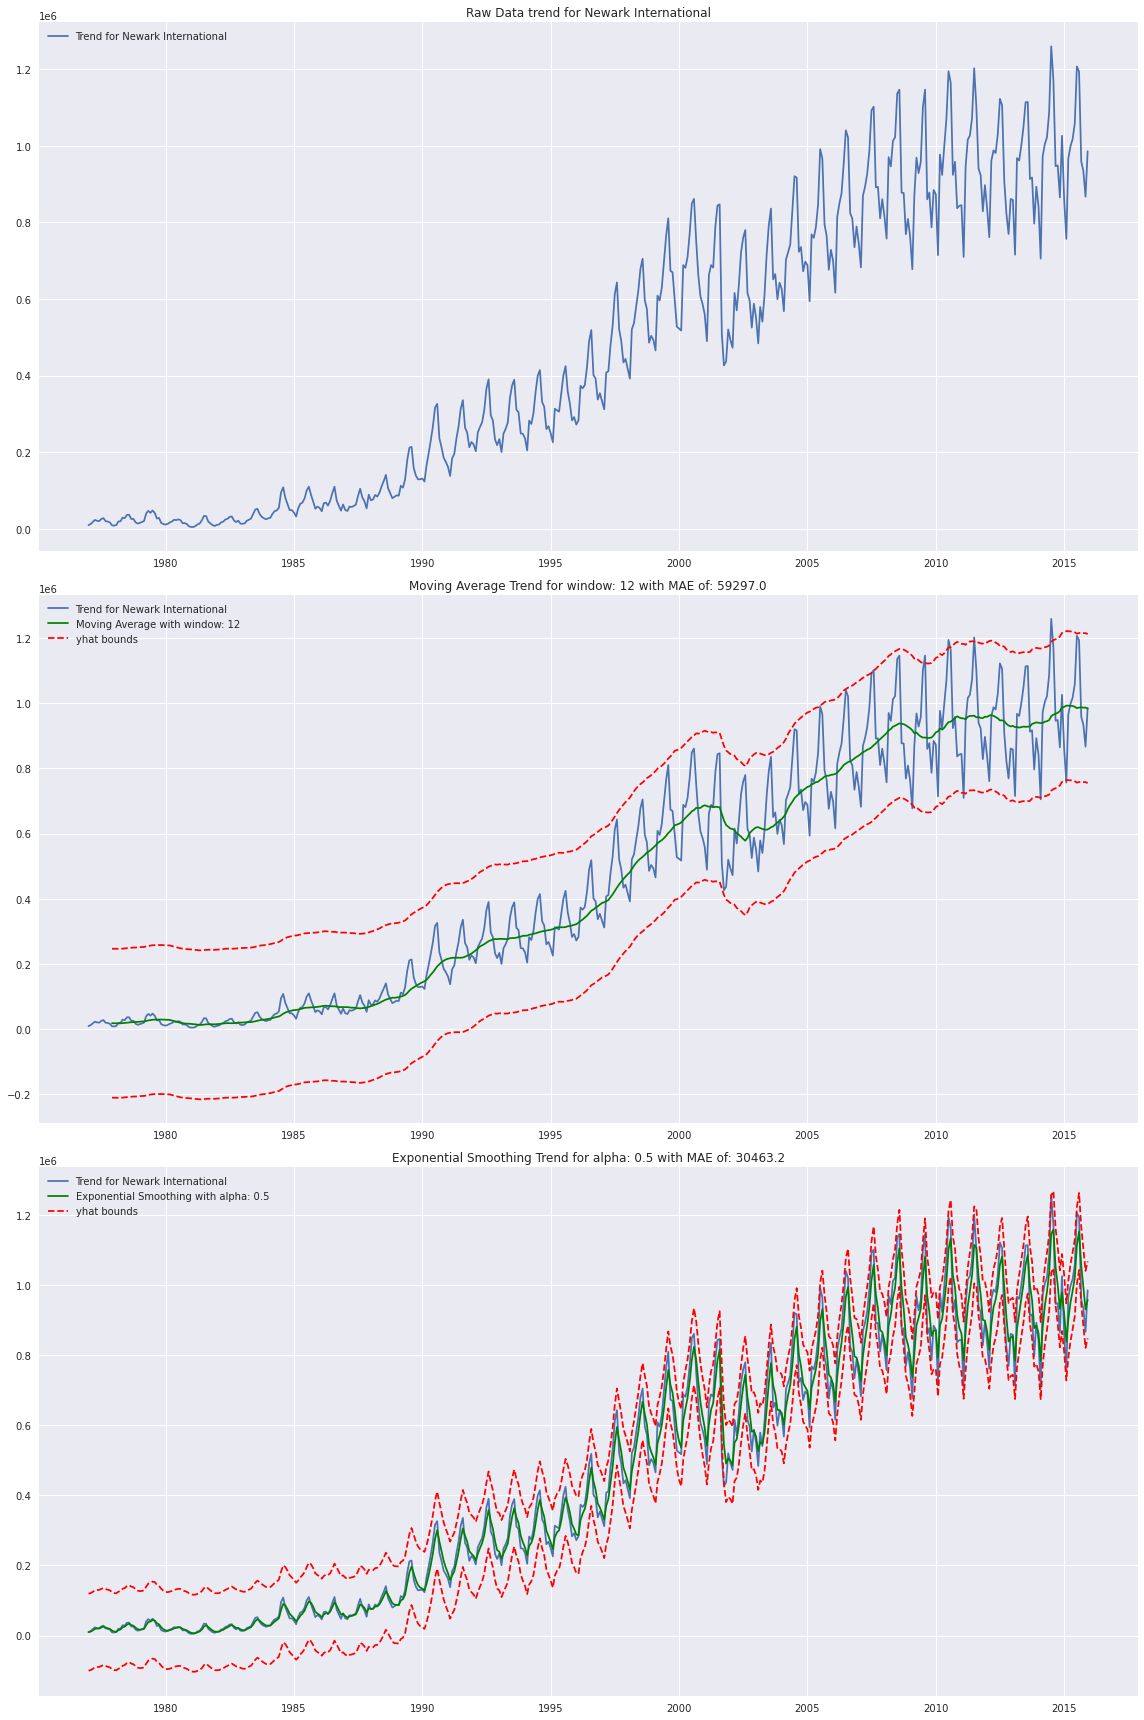

In [6]:
ewr_data = get_airport_data('EWR', DATA_PATH)
# We're changing the alpha value here from the text of the book to show the magnitude of difference when changing
# this value. With the book's alpha value of 0.25 (more smoothing), we achieved an MAE of 50487.9, which isn't 
# that much of an improvement compared to the moving average.
# HOWEVER, if we were to go with this approach for forecasting a few months in advance, we would want to strike
# a balance between the alpha level, the window, and recursive nature of that forecast for 'n' months in the future.
ewr_reference = smoothed_time_plots(ewr_data['International Passengers'], 'Newark International', 
                                    'newark_dom_smooth_plot.svg', 12, exp_alpha=0.5)

As mentioned in the code note above, we changed the value of alpha as compared to the text in the book. For further understanding of what a selection of this approach as a solution would entail...
> A fun series of thought / coding excercises:
- If you wanted to actually use this approach to model out a year in the future, what approach would you take? 
- Recursively looping over each value to continue the series?
- How would you set the window and the alpha to make the exponential smoothing work?
- What would the effect of the window over forecast values (as time moves on) do to the values if we went 10 years in the future? Would it be accurate, or would it converge to the mean?
- Is this going to adapt to sudden changes very well? What does this mean to how far in the future we can safely forecast?

### Listing 6.5 Simple MAPE Implementation
This short listing shows a custom implementation of a metric that isn't included in standard libraries. It's a fairly standard one that is easy enough to implement. An important step to take before doing such a thing, though, is to <b>check standard libraries first</b> to make sure that the community hasn't come up with a solution already. Even for simple things such as this (FYI the MAE calculation used before isn't particularly challenging to implement either) it's always best to minimize the total size of risk in your code base by using what everyone else is using. The fewer custom implementations that exist in your code, the less the risk of inaccuracies in your implementation and the fewer lines of code (and unit tests) that you have to write.
> NOTE: we're not going to use only MAPE. Like any other scoring metric, there are limitations. I've personally found it best to collect all of the applicable scoring metrics for any model that I'm training and validating. There's nothing more annoying than finding out halfway through prototyping that a metric other than what you started out with is actually more applicable to the problem than what you had been using. Collecting as many as you can allows you to have a historical record of experiments with all of the metrics available to track the history of what you've done as compared to where you are at present. These calculations are very cheap (for the most part) and you really don't have anything to lose by capturing as many useful ones as you can from the start.

In [7]:
""" Function for calculating mean absolute percentage error (for comparing models of different series magnitudes
      to one another for objective quality comparison)
:param y_true: the 'validation' series (a.k.a. 'test')
:param y_pred: the forecast series (a.k.a. the result of a '.predict()' method call)
"""
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Listing 6.6 Standard Error calculations for scoring forecast data
In this section, we're going to be addressing what I mentioned in the note in listing 6.5 above. We're going to capture all of the 'standard ones' (don't worry, we'll be adding more to this in Chapter 7 for reasons that will be explained in that chapter).

In [8]:
""" Function to calculate the 'core' forecasting error metrics for a regression problem.
:param y_true: the test series (ground truth holdout data)
:param y_pred: the forecast (predicted) series
"""
def calculate_errors(y_true, y_pred):
    # create a dictionary to store all of the metrics
    error_scores = {}
    
    # define a variable for mse since it's going to be used to store itself in the dictionary but also because
    # it's going to be used to calculate the rmse value.  This is to keep your mse call in a single place
    # so that you're not calculating the same thing twice (remember: every electron is precious)
    # but also to keep your code cleaner.
    mse = mean_squared_error(y_true, y_pred)
    
    # store all of the metrics into the dictionary for ease of access later. 
    #  (don't return tuples - it's a bad practice because it's really hard for other humans to read)
    error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    error_scores['mape'] = mape(y_true, y_pred)
    
    # here's what I was talking about earlier. We're going to use the calculated-once variable of mse to 
    # put into the dictionary.
    # Alternatively, the amateurish approach here would have been:
    #
    # error_scores['mse'] = mean_squared_error(y_true, y_pred)
    # error_scores['rmse'] = sqrt(mean_squared_error(y_true, y_pred))
    #
    # Not only would you be double calculating the mean squared error, but it just looks silly.
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    error_scores['r2'] = r2_score(y_true, y_pred)
    return error_scores

### Listing 6.7 Prediction forecast plotting with error metrics
Now it's time to create the code that will allow us to plot a forecast, the ground truth data, and all of the error metrics in one place. This is the final stage before we can start to actually get to testing the different approaches for solving this problem that we researched.
> We won't be visualizing this.... yet. We don't have any predictions calculated. It's good to have this built <b><i><u>before we start modeling</u></i></b> so that we don't have multiple groups creating different versions of the same boilerplate visualization. It also helps to have a standardized format so that we can quickly assess the different experiments without having to 'train our eyes' to look at different plots.

In [9]:
""" Function for a standardized forecasting visualization that can be used for all experiments being conducted
:param y_true: the ground-truth values during the forecasting period that we'll be using for validation (holdout data)
:param y_pred: the forecast values during the holdout period
:param time_series_name: a name for the plot
:param value_name: the name for our y-axis on the plot
:param image_name: the name of the file to save the visualization as in svg format
:param style: (default 'seaborn') the visual style of the plots
:param plot_size: (default 16 x 12 inches) the size of the figure we're going to generate
"""
def plot_predictions(y_true, y_pred, time_series_name, value_name, image_name, style='seaborn', plot_size=(16, 12)):
    # dictionary for currying
    validation_output = {} 
    
    # full error metrics suite as shown in listing 6.6
    error_values = calculate_errors(y_true, y_pred)
    
    # store all of the raw values of the errors
    validation_output['errors'] = error_values
    
    # create a string to populate a bounding box with on the graph
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    )) 
    with plt.style.context(style=style):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left')
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        
        # create an overlay bounding box so that all of our metrics are displayed on the plot
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)
        validation_output['plot'] = fig
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return validation_output


### Listing 6.8 Time split for train and test data sets (with validation check)
I promise, this is the last 'pre work' we need to do before testing our theories. These two functions are designed to help standardize the team on how they're conducting their individual tests of different algorithms. In order to make sure that everything is truly a level playing field in the comparisons between different approaches, we absolutely <b><u> have got to ensure </u></b> that everyone is splitting their data in the same way. This is particularly important for time series regression problems as the influence that the last value of the training data set has over the forecast is quite a bit stronger than other ML algorithms. 

In [10]:
""" Utility function for making sure that the split that we conducted split the data correctly
:param data: the full data set
:param train: the train portion of the data set
:param test: the test portion of the data set
"""
def split_correctness(data, train, test):
    assert data.size == train.size + test.size, \
    "Train count {} and test count {} did not match to source count {}".format(train.size, test.size, data.size)

""" Function for splitting the 'raw' data between train and test at a boundary point that is specified as a 
      parse-able date format.
:param data: the raw data
:param date: a date, in a format that 'can be parsed' to serve as the boundary point
"""
def generate_splits(data, date):
    parsed_date = parse(date, fuzzy=True)
    nearest_date = data[:parsed_date].iloc(0)[-1].name
    train = data[:nearest_date]
    test = data[nearest_date:][1:]
    split_correctness(data, train, test)
    return train, test


Let's test this real quick... just to see what happens when we pass different elements into this.

In [11]:
jfk_raw_data = get_airport_data('JFK', DATA_PATH)
jfk_train_check, jfk_test_check = generate_splits(jfk_raw_data, "2010-04-13")
jfk_train_check.tail(2)

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
2010-03-01,JFK,2010,3,1929849,1736163,3666012,1
2010-04-01,JFK,2010,4,1883394,1741319,3624713,1


In [12]:
jfk_train_check2, jfk_test_check2 = generate_splits(jfk_raw_data, "3 march 2009")
jfk_train_check2.tail(2)

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
2009-02-01,JFK,2009,2,1668416,1335194,3003610,1
2009-03-01,JFK,2009,3,2036804,1617790,3654594,1


In [13]:
ben_being_ridiculous_train, ben_being_ridiculous_test = generate_splits(jfk_raw_data, "The 4th of July 06")
ben_being_ridiculous_train.tail(2)

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
2006-06-01,JFK,2006,6,1906245,1847236,3753481,1
2006-07-01,JFK,2006,7,2163771,2047036,4210807,1


Date parsers are pretty cool. The point that I'm trying to make here, however, is that with <b><i>standardized implementations for performing critical operations like train/test splits</i></b> that every team member (including just yourself if you're working alone) will be using can eliminate a bit of the chaos of the experimentation phase. It simply means <u><i>one less thing you'll have to worry about</i></u>, making it so that the team can focus on what is important coming up: rapid prototyping and testing out approaches to make a decision on the simplest way to solve the problem.

### Listing 6.9 A rough first-pass at a VAR model
We're going to be making some hot garbage here. Intentionally for demonstration purposes, but also to illustrate what <b><u>all of us go through when using an API for the first time</u></b> (particularly if we didn't read the API docs or checked out the theory behind the algorithm and truly understand what it is that this high-level API is actually wrapping itself around.
> This is intentionally bad.

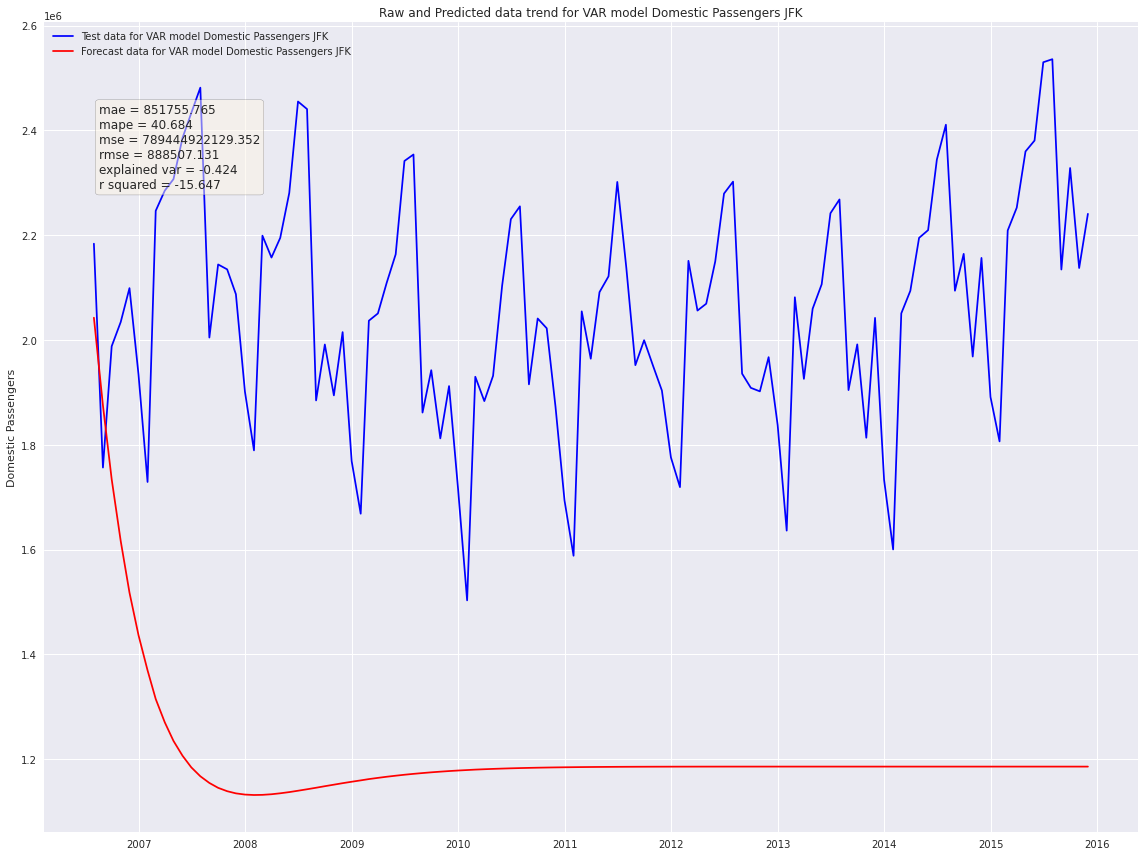

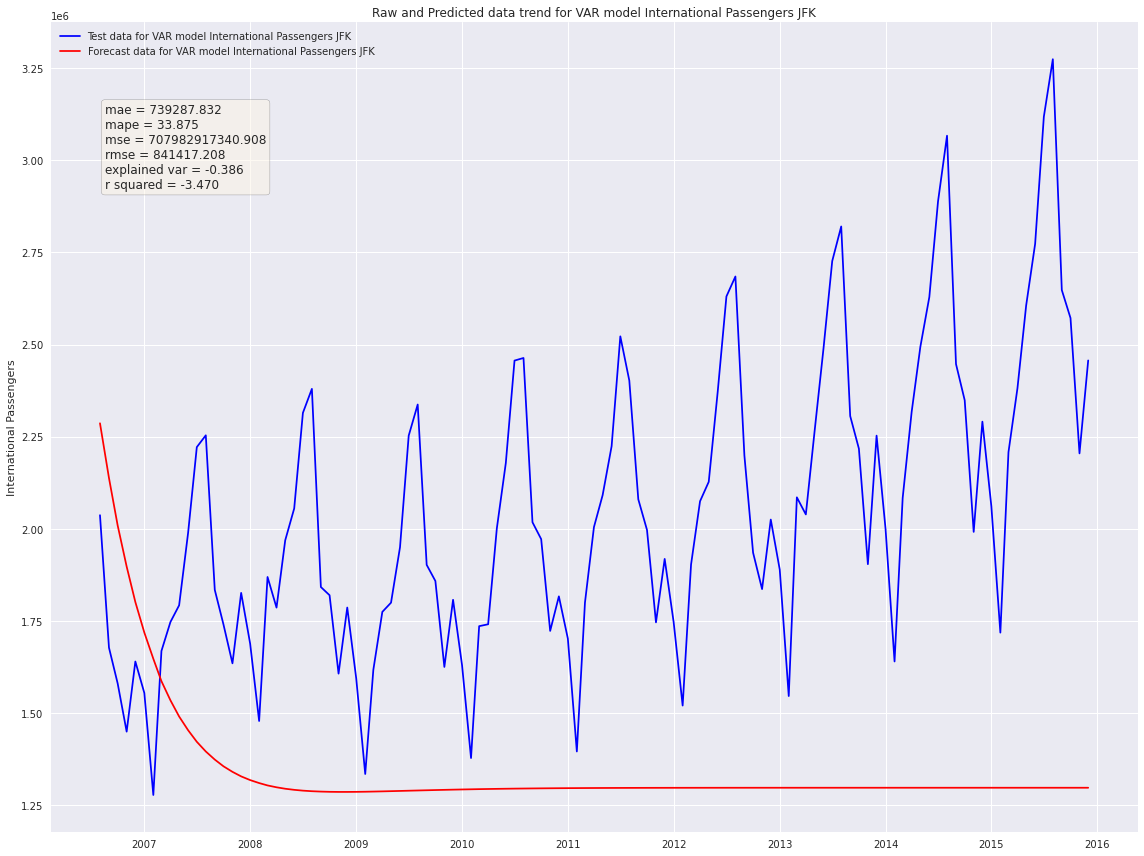

In [14]:
jfk = get_airport_data('JFK', DATA_PATH)
jfk = apply_index_freq(jfk, 'MS')
train, test = generate_splits(jfk, '2006-07-08')

# seemed like the API docs said that you could model multiple series with this at the same time? That's cool!
var_model = VAR(train[['Domestic Passengers', 'International Passengers']])

# I think this is the autocorrelation differencing order? Yearly seems like it might work?
var_model.select_order(12)

# sure, let's fit it. Hope for the best!
var_fit = var_model.fit()

# The example in the docs used this? I guess?
lag_order = var_fit.k_ar

# I think this was how to get a prediction out of this model.
var_pred = var_fit.forecast(test[['Domestic Passengers', 'International Passengers']].values[-lag_order:], 
                            test.index.size)

# To plot all of this, we'll need to extract the predictions from the forecast data. Geez this seems complex...
var_pred_dom = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_intl = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)

# Let's use our plot_predictions() function to see how we did!
var_prediction_score = plot_predictions(test['Domestic Passengers'], 
                                        var_pred_dom, 
                                        "VAR model Domestic Passengers JFK", 
                                        "Domestic Passengers", 
                                        "var_jfk_dom.svg")

var_prediction_score_intl = plot_predictions(test['International Passengers'], 
                                        var_pred_intl, 
                                        "VAR model International Passengers JFK", 
                                        "International Passengers", 
                                        "var_jfk_intl.svg")

That... could have gone better. What the heck happened?!!
1. We didn't really read the docs.
2. We didn't check out the algorithm and see how it works to inform what we should be doing with hyperparameters or the series itself.
Don't worry about results like this. We all get them. As time goes on, though, you'll realize that reading the API docs <b>before you attempt to use the API</b> will save you a great deal of time. You'll also realize that the defaults for every single model are simply just 'guesses' by the algorithm developer and are meant to be placeholders.

### Listing 6.10 Let's give VAR another shot after we read the docs
Let's see what we've learned by reading through the API docs on the developer's website. Turns out that the .fit() method actually needs an autoregressive term in order to perform properly! Let's see what happens when we add that in.

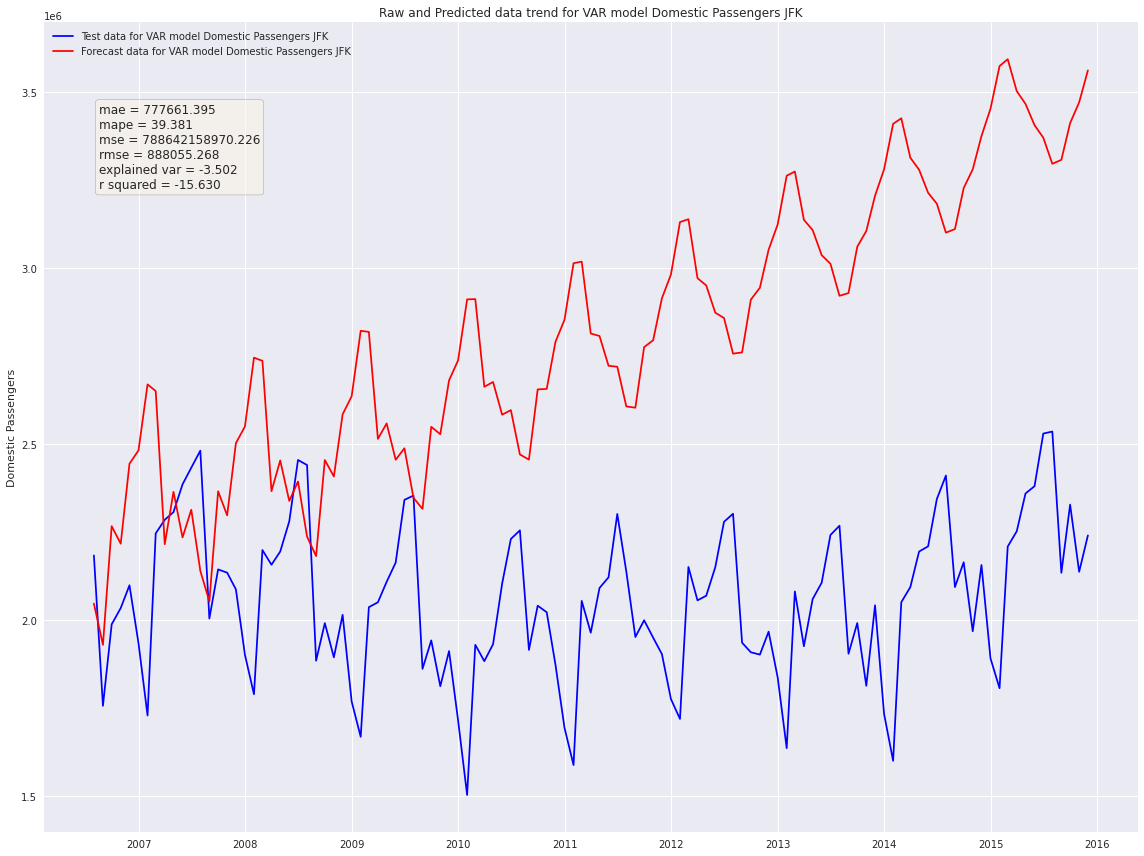

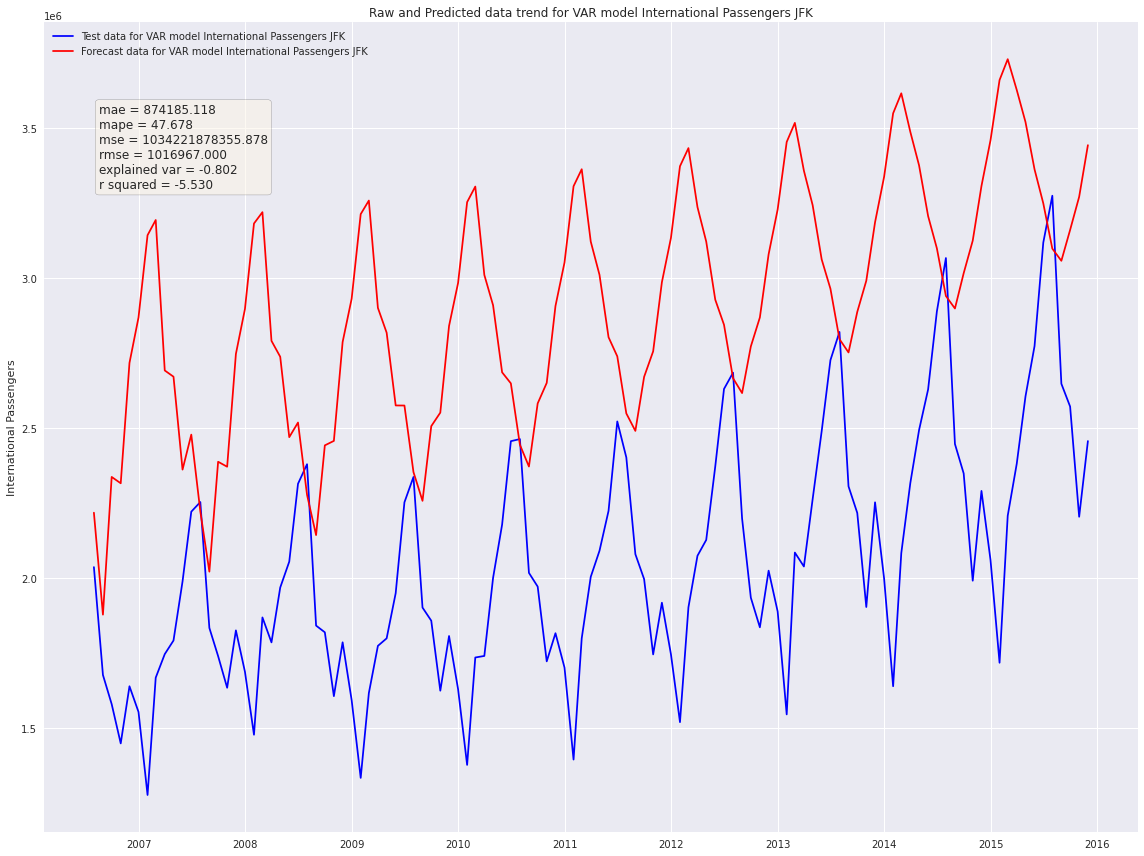

In [15]:
var_model = VAR(train[['Domestic Passengers', 'International Passengers']])
var_model.select_order(12)
var_fit = var_model.fit(12)
lag_order = var_fit.k_ar
var_pred = var_fit.forecast(test[['Domestic Passengers', 'International Passengers']].values[-lag_order:], test.index.size)
var_pred_dom = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_intl = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)
var_prediction_score = plot_predictions(test['Domestic Passengers'], 
                                        var_pred_dom, 
                                        "VAR model Domestic Passengers JFK", 
                                        "Domestic Passengers", 
                                        "var_jfk_dom_lag12.svg")
var_prediction_score_intl = plot_predictions(test['International Passengers'], 
                                        var_pred_intl, 
                                        "VAR model International Passengers JFK", 
                                        "International Passengers", 
                                        "var_jfk_intl_lag12.svg")


I mean.. it's better than the first attempt. But... the magnitudes look shifted at each seasonality boundary. Is this model a good candidate?

### Listing 6.11 Stationarity adjusted predictions with a VAR model
Here we're going to show the results after we've not only read the API docs, but read up on the actual algorithm itself. As it turns out, VAR models don't deal with non-stationarity very well. They really like a stable mean-and-variance-stable series. We can <b><u>make the trend stationary</u></b> though, with a bit of very basic math.

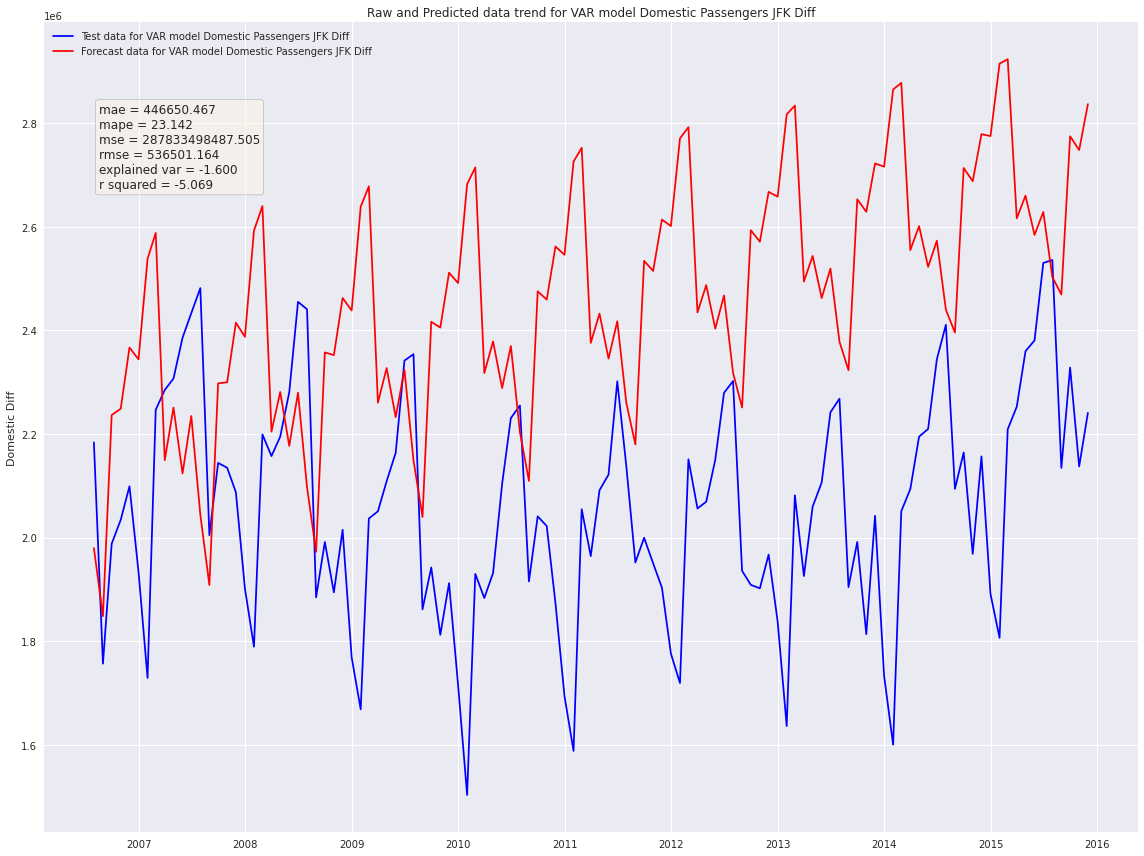

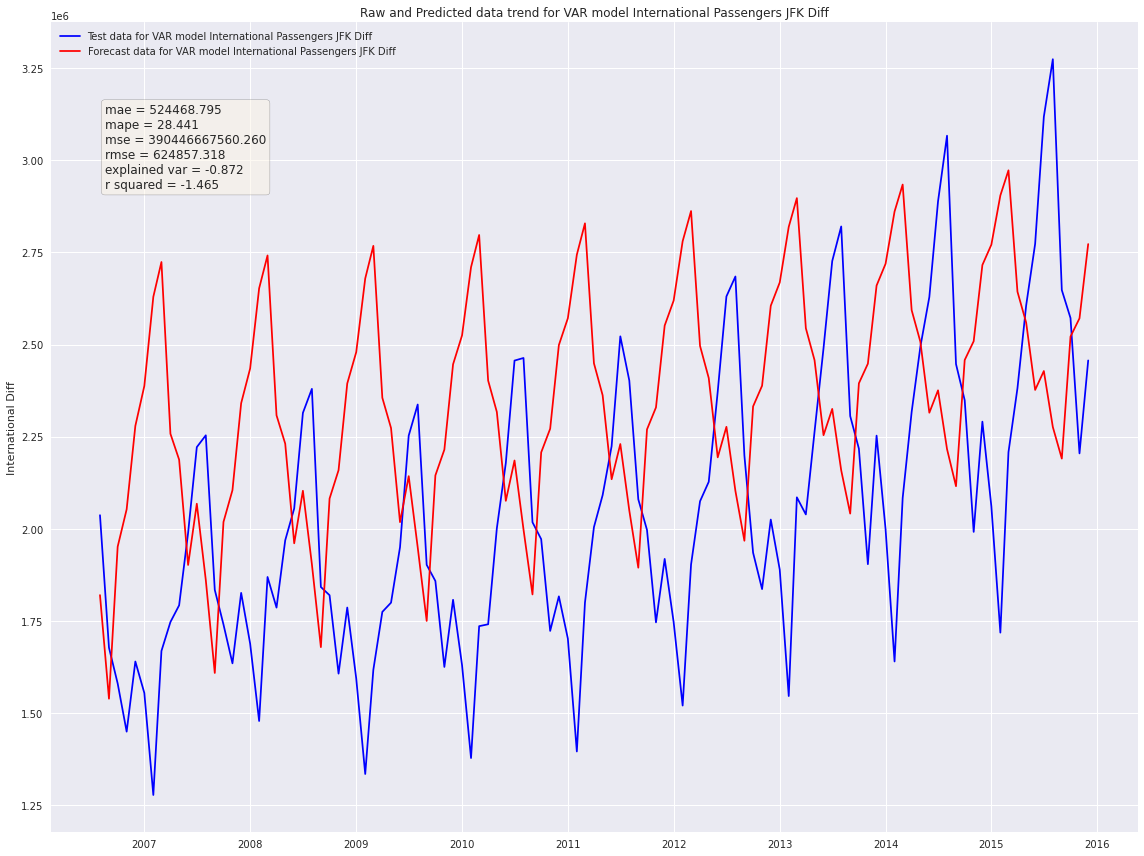

In [16]:
jfk_stat = get_airport_data('JFK', DATA_PATH)
jfk_stat = apply_index_freq(jfk, 'MS')

# Let's take the log of the series, then do a basic differencing function on the data
jfk_stat['Domestic Diff'] = np.log(jfk_stat['Domestic Passengers']).diff()
jfk_stat['International Diff'] = np.log(jfk_stat['International Passengers']).diff()

# since we're differencing, we need to drop the leading value from the series as it is null.
jfk_stat = jfk_stat.dropna()
train, test = generate_splits(jfk_stat, '2006-07-08')
var_model = VAR(train[['Domestic Diff', 'International Diff']])
var_model.select_order(6)
var_fit = var_model.fit(12)
lag_order = var_fit.k_ar
var_pred = var_fit.forecast(test[['Domestic Diff', 'International Diff']].values[-lag_order:], test.index.size)
var_pred_dom = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_intl = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)

# After modeling is complete and the forecast is generated, we need to remove the differencing aspect and then 
# invert the log values to get back to the original numeric space.
var_pred_dom_expanded = np.exp(var_pred_dom.cumsum()) * test['Domestic Passengers'][0]
var_pred_intl_expanded = np.exp(var_pred_intl.cumsum()) * test['International Passengers'][0]
var_prediction_score = plot_predictions(test['Domestic Passengers'], 
                                        var_pred_dom_expanded, 
                                        "VAR model Domestic Passengers JFK Diff", 
                                        "Domestic Diff", 
                                        "var_jfk_dom_lag12_diff.svg")
var_prediction_score_intl = plot_predictions(test['International Passengers'], 
                                        var_pred_intl_expanded, 
                                        "VAR model International Passengers JFK Diff", 
                                        "International Diff", 
                                        "var_jfk_intl_lag12_diff.svg")


Once again, it's better..... but it's not great. We have this weird inversion of the seasonality trend, a divergence of the data for domestic passengers, and the variance reduces as time goes on. Let's call it quits on the prototype phase for this approach. 
> What did we learn here?
- We learned a new API
- We understood the complexity of using this model (transformations that need to happen that hamper the model's ability to respond to the directional shift of the series) 
- We got a feel for what 'knobs' (hyperparameters) we can turn with this model<br>

We don't really have to do any more here. If this model ends up being the most promising of all of the other solutions, we'll dig deep into tuning it as we build the MVP. If we don't end up selecting it, then, there's really not much time lost in an investment here. The <b>absolute worst thing that we could have done here</b> would be to spend days (or weeks) trying to make this <u><i>prototype</i></u> as good as it possibly could be, only to find out after all of that effort and work that there was a simpler solution (or one that is arguably more complex, but its results outweigh the complexity through sheer quality of forecasting).


#### Bonus round - try supervised Linear models
>This section isn't in the book, but it was originally intended to be. <br>
In this section we're going to be looking at seeing how different linear models perform as a comparison to the other implementations. We'll be testing out:
    - LinearRegression
    - Ridge (with cross validation)
    - Lasso (with cross validation)
    - ElasticNet (with cross validation)
    - an unweighted mean ensemble of all of them
With these comparisons, we can further expand our prototyping for the comparison of these approaches so that we make an informed decision about the most promising approach to sink development time into.

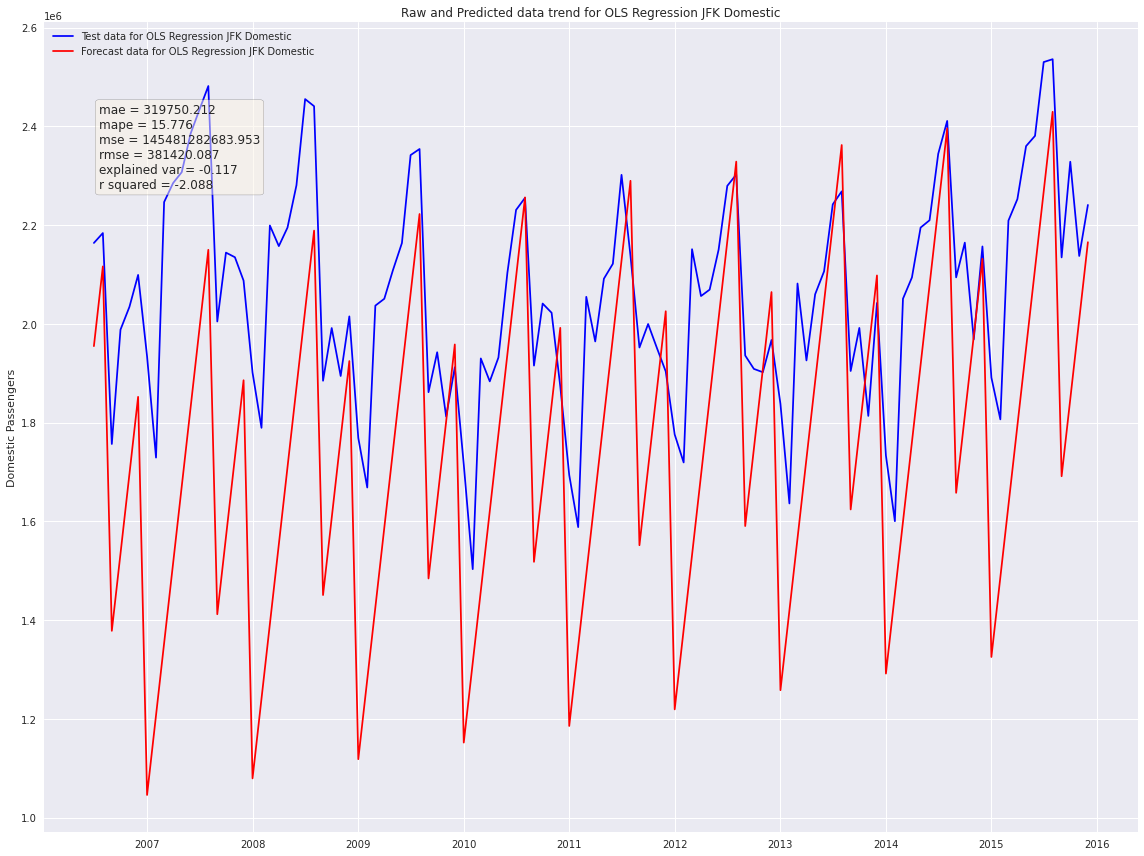

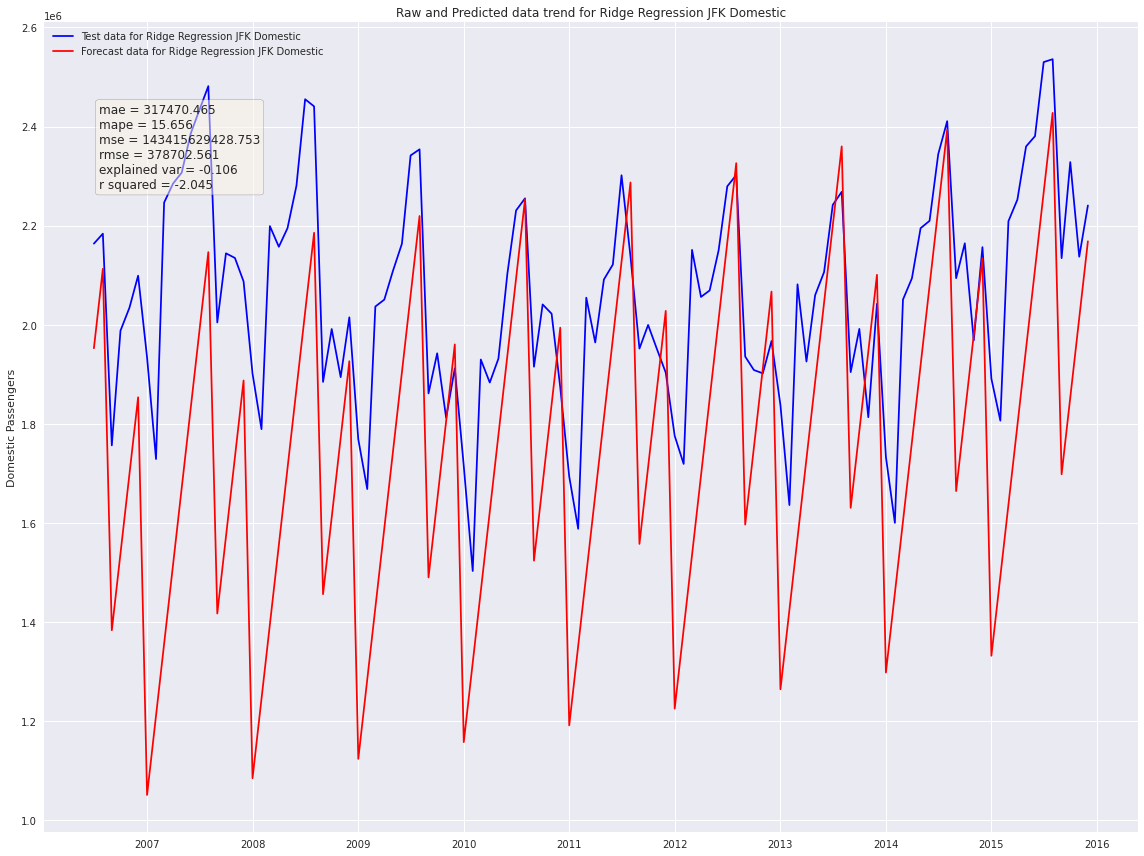

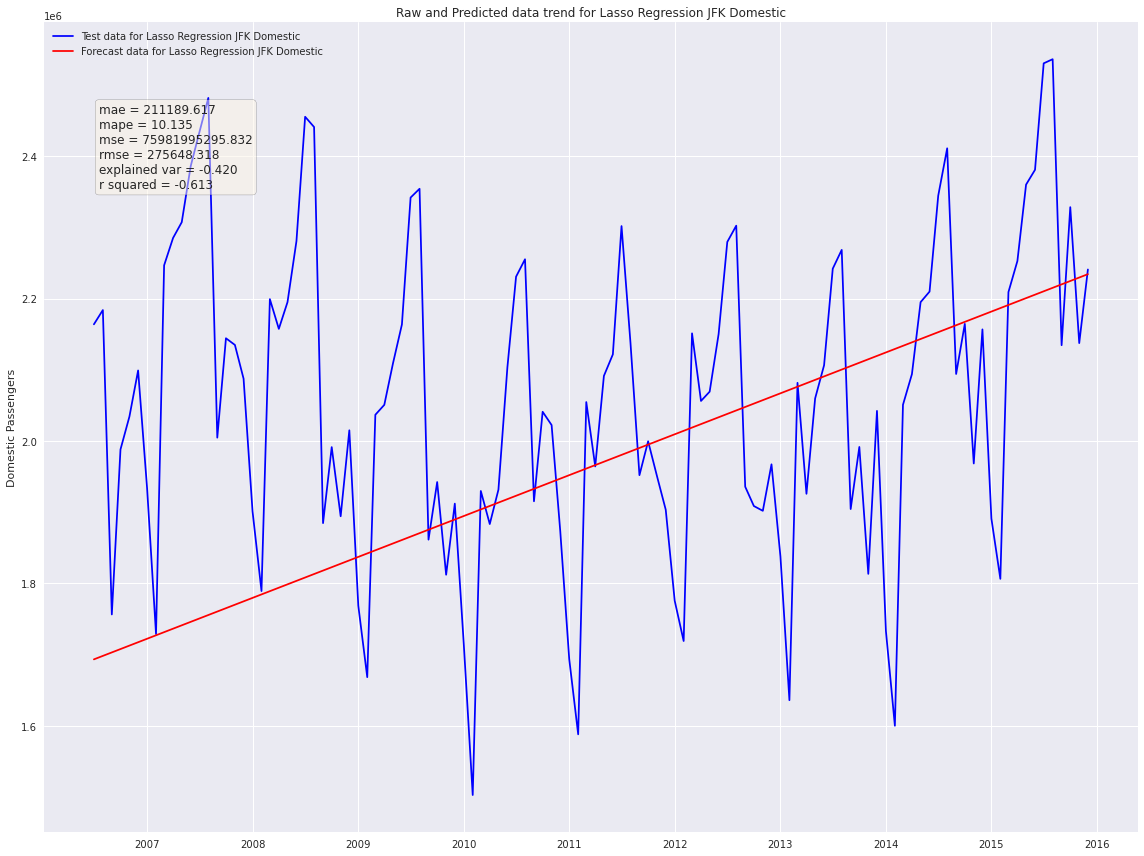

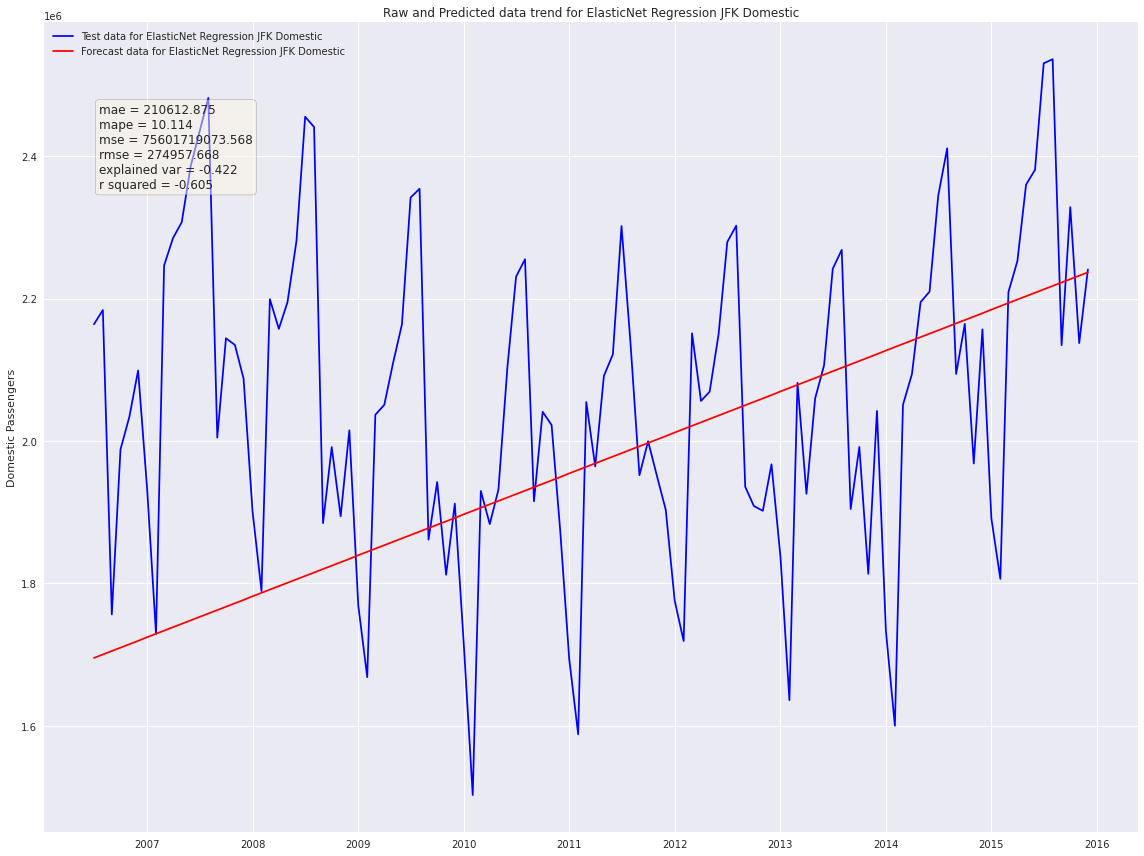

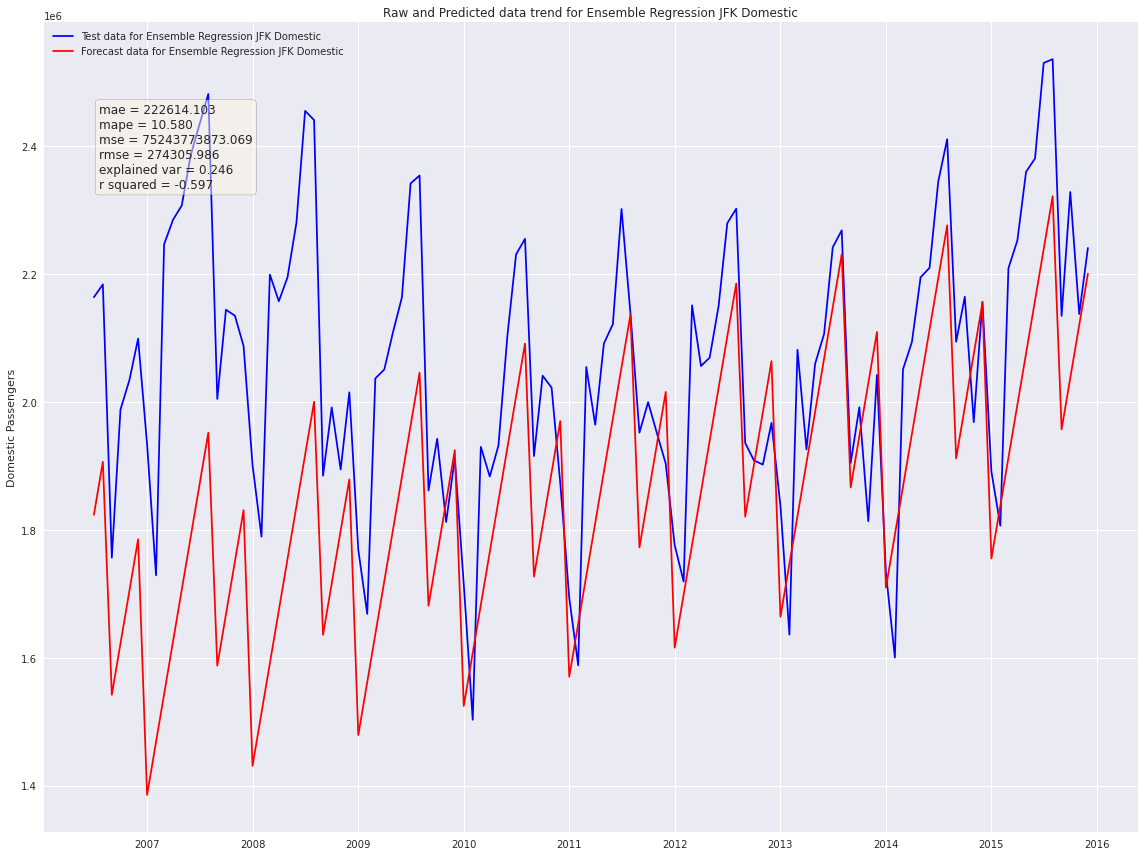

In [17]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

jfk_linear = get_airport_data('JFK', DATA_PATH)

jfk_linear['months_from_start'] = (jfk_linear.index - jfk_linear.index[0])/np.timedelta64(1, 'M')
jfk_linear['years_from_start'] = (jfk_linear['Year'] - jfk_linear['Year'][0])
jfk_linear['holiday_travel'] = (jfk_linear['Month'] >= 9) * 1

X = jfk_linear[['months_from_start', 'years_from_start', 'holiday_travel']]
Y = jfk_linear[['Domestic Passengers']]

date_cutoff = '2006-06-10'
X_train, X_test = generate_splits(X, date_cutoff)
Y_train, Y_test = generate_splits(Y, date_cutoff)
Y_train_arr = Y_train.values.ravel()
Y_test_arr = Y_test.values.ravel()

lr = LinearRegression(
    fit_intercept=False,
    normalize=False
).fit(X_train, Y_train_arr)

lr_validate = Y_test.copy(deep=False)
lr_validate['prediction'] = lr.predict(X_test)

ridge = RidgeCV(
    alphas=[0.1, 0.5, 0.7, 0.95, 1.0, 10.0],
    fit_intercept=False,
    normalize=True,
    gcv_mode='auto' # 'svd', 'eigen'
).fit(X_train, Y_train_arr)

ridge_validate = Y_test.copy(deep=False)
ridge_validate['prediction'] = ridge.predict(X_test)

lasso = LassoCV(
    eps=1e-3,
    n_alphas=100,
    fit_intercept=False,
    normalize=False,
    precompute='auto',
    tol=1e-8,
    selection='cyclic', #cyclic
    random_state=42
).fit(X_train, Y_train_arr)

lasso_validate = Y_test.copy(deep=False)
lasso_validate['prediction'] = lasso.predict(X_test)

elastic = ElasticNetCV(
    l1_ratio=[1e-6, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0],
    n_alphas=100,
    fit_intercept=False,
    normalize=False,
    precompute='auto',
    tol=1e-4,
    positive=False,
    selection='random', #cyclic
    random_state=42
).fit(X_train, Y_train_arr)

elastic_validate = Y_test.copy(deep=False)
elastic_validate['prediction'] = elastic.predict(X_test)

# what if we average them together in an ensemble?
ensemble = Y_test.copy(deep=False)
ensemble['ols'] = lr.predict(X_test)
ensemble['ridge'] = ridge.predict(X_test)
ensemble['lasso'] = lasso.predict(X_test)
ensemble['elastic'] = lasso.predict(X_test)
ensemble['prediction'] = ensemble[['ols', 'ridge', 'lasso', 'elastic']].mean(axis=1)

# Let's see what OLS regression can do for us...
ols_plot = plot_predictions(Y_test['Domestic Passengers'], lr_validate['prediction'], 
                 'OLS Regression JFK Domestic','Domestic Passengers', 'ols_reg.svg')
# Check ridge regression
ridge_plot = plot_predictions(Y_test['Domestic Passengers'], ridge_validate['prediction'], 
                 'Ridge Regression JFK Domestic', 'Domestic Passengers', 'ridge.svg')
# and Lasso
lasso_plot = plot_predictions(Y_test['Domestic Passengers'], lasso_validate['prediction'], 
                 'Lasso Regression JFK Domestic', 'Domestic Passengers', 'lasso.svg')
# and ElasticNet
enet_plot = plot_predictions(Y_test['Domestic Passengers'], elastic_validate['prediction'], 
                 'ElasticNet Regression JFK Domestic', 'Domestic Passengers', 'enet.svg')
# see what the ensemble looks like
ensemble_plot = plot_predictions(Y_test['Domestic Passengers'], ensemble['prediction'], 
                 'Ensemble Regression JFK Domestic', 'Domestic Passengers', 'ensemble.svg')

Well, at least we now know why using these types of models are pretty terrible for non-stationary series. We could always add more information to the feature vector, enforce stationarity in the target during training and scoring, or add additional data to try to make it more accurate. 

> NOTE: this is the entire point of a large swath of this book. All of those 'ideas' are not the goal of the prototyping phase. Exploring means of improving a less than optimal result is part of building an <b>MVP</b>, not a basic prototype. Implementing additional ideas that take more than a few hours should only be pursued once all other implementation options have been exhausted through their own prototyping. If we spent time 'building up a better feature vector' due to the fact that we didn't <i><u>research other approaches</u></i> it could take weeks of work to figure out something that isn't complete garbage (side note: the predictions above this are, in all actuality, total hot garbage). 

<br>
Don't let you or your team fall into the 'if you only have a hammer, everything looks like a nail' trap and only work with the models that people are posting about in blogs (if you do that, you'll try to use TensorFlow, Pytorch, XGBoost, LightGBM, or Catboost for every ML problem... to the detriment of your projects and IT budget). Stick to the prototyping paradigm and move on to test out other ideas before focusing on something that doesn't seem to be working for the problem at hand.

### Listing 6.12 Final state of the ARIMA experimentation
We're going to save some time here. Let's see what an ARIMA implementation looks like <i><b>after we read the API docs and learn the algorithm</b></i>


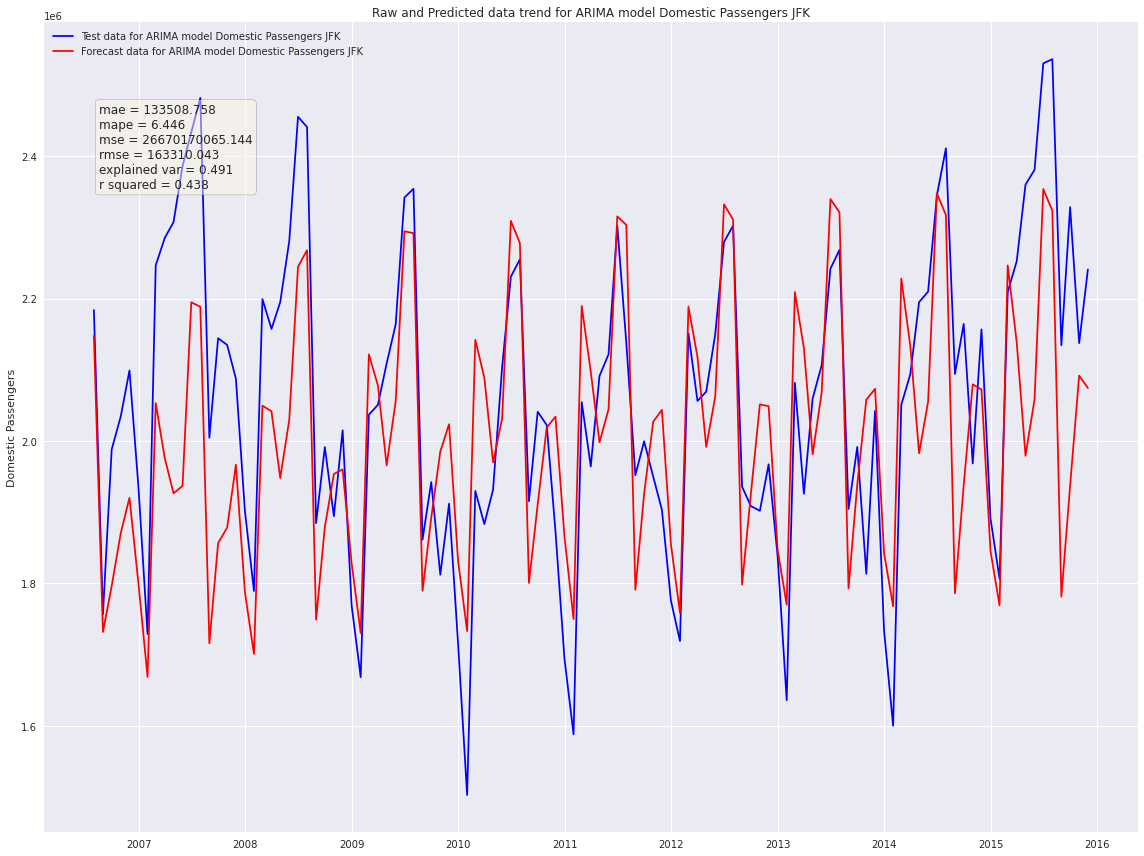

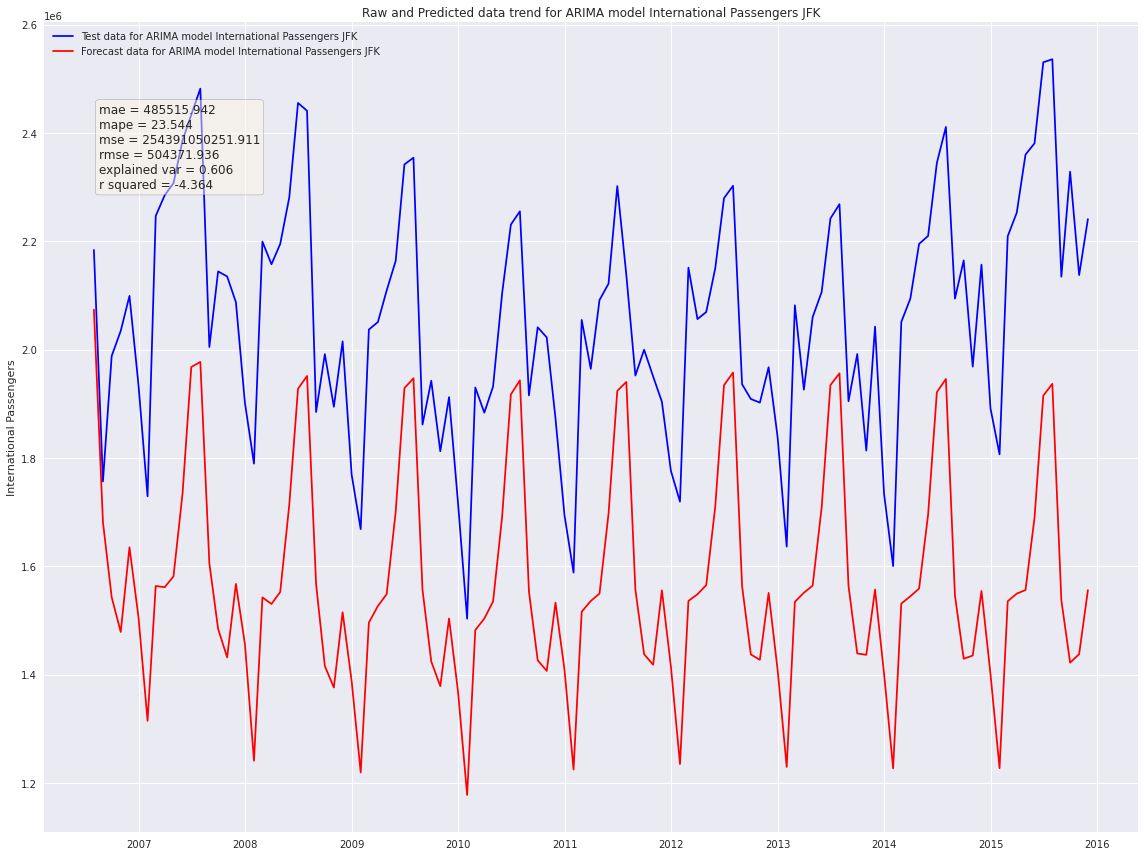

In [18]:
jfk_arima = get_airport_data('JFK', DATA_PATH)
jfk_arima = apply_index_freq(jfk_arima, 'MS')
train, test = generate_splits(jfk_arima, '2006-07-08')

# We tested some of these hyperparameters and read what they mean to the performance of the algorithm's ability to 
#   optimize to our data
arima_model = ARIMA(train['Domestic Passengers'], order=(48,1,1), enforce_stationarity=False, trend='c')
arima_model_intl = ARIMA(train['International Passengers'], order=(48,1,1), enforce_stationarity=False, trend='c')
arima_fit = arima_model.fit()
arima_fit_intl = arima_model_intl.fit()
arima_predicted = arima_fit.predict(test.index[0], test.index[-1])
arima_predicted_intl = arima_fit_intl.predict(test.index[0], test.index[-1])
arima_score_dom = plot_predictions(test['Domestic Passengers'],
                                   arima_predicted,
                                   'ARIMA model Domestic Passengers JFK',
                                   'Domestic Passengers',
                                   'arima_jfk_dom_2.svg'
                                   )
arima_score_intl = plot_predictions(test['Domestic Passengers'],
                                    arima_predicted_intl,
                                    'ARIMA model International Passengers JFK',
                                    'International Passengers',
                                    'arima_jfk_intl_2.svg'
                                    )


You might notice that this one took <i>just a little more time to run</i> than the VAR models did. This is due to our hyperparameters that we're testing. With a period order of 48, that's an awful lot of data to be recursing over through the autoregressive model's approach. The results seem to be <b><u>much better than the VAR model</u></b>, though. We might be on to something here with ARIMA...
> The biggest thing to note here is the fact that we tuned both of these forecasts with <b><i>the same hyperparameters</i></b> and they have drastically different results with respect to matching the mean and variance of the hold-out data. This clues us in to the fact that we're going to have to individually tune each of the time series forecasts (an even greater argument regaring not using the defaults!). There will be much more to come on this topic in Chapter 7.

### Listing 6.13 Holt-Winters Exponential Smoothing function and usage
The code below is the final prototype version of Holt-Winters Exponential Smoothing algorithm for forecasting. As can be clearly seen, there are a few more hyperparameters at play here than with earlier models that were tested. With 12 in total, manual tuning is going to be a non-starter if this model is selected for the MVP development phase. 
> Note: The model, its fit, and the forecasting are wrapped in a function here, as opposed to the scripted approach that we were using before.  It is <b>strongly recommended</b> that even in a prototype phase with a limited amount of testing (manual testing though it may be), using a function to wrap around tuning logic can make it far easier to keep track of different configurations that are tested within a notebook through function calls with alternate parameters in different cells. 
>> For an in-depth explanation of this algorithm and what some of the hyperparameters are actually <i>doing</i> to influence the optimization of this algorithm (a triple exponential smoothing recursive approach developed in 1960 by Professor Charles C. Holt and his student Peter Winters), you can check out the original paper that defined the single, double, and (the one we're using here, the triple) algorithm: https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324

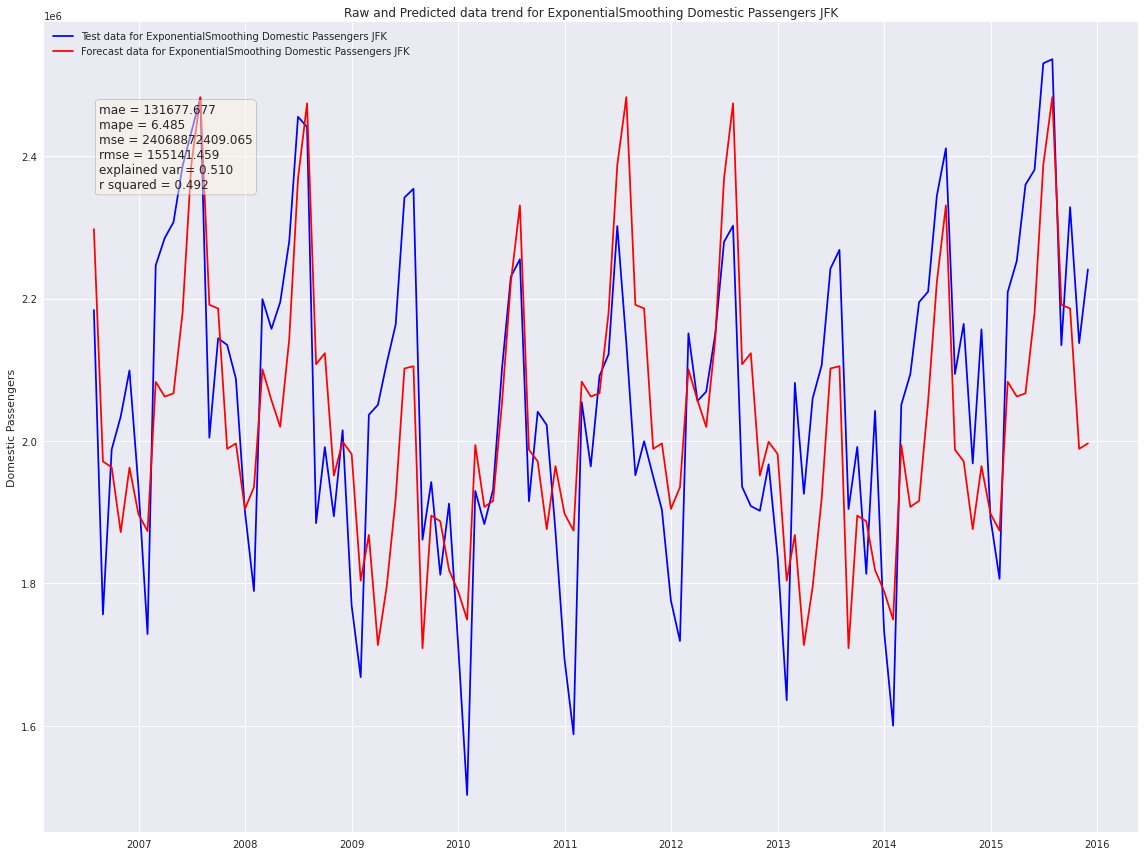

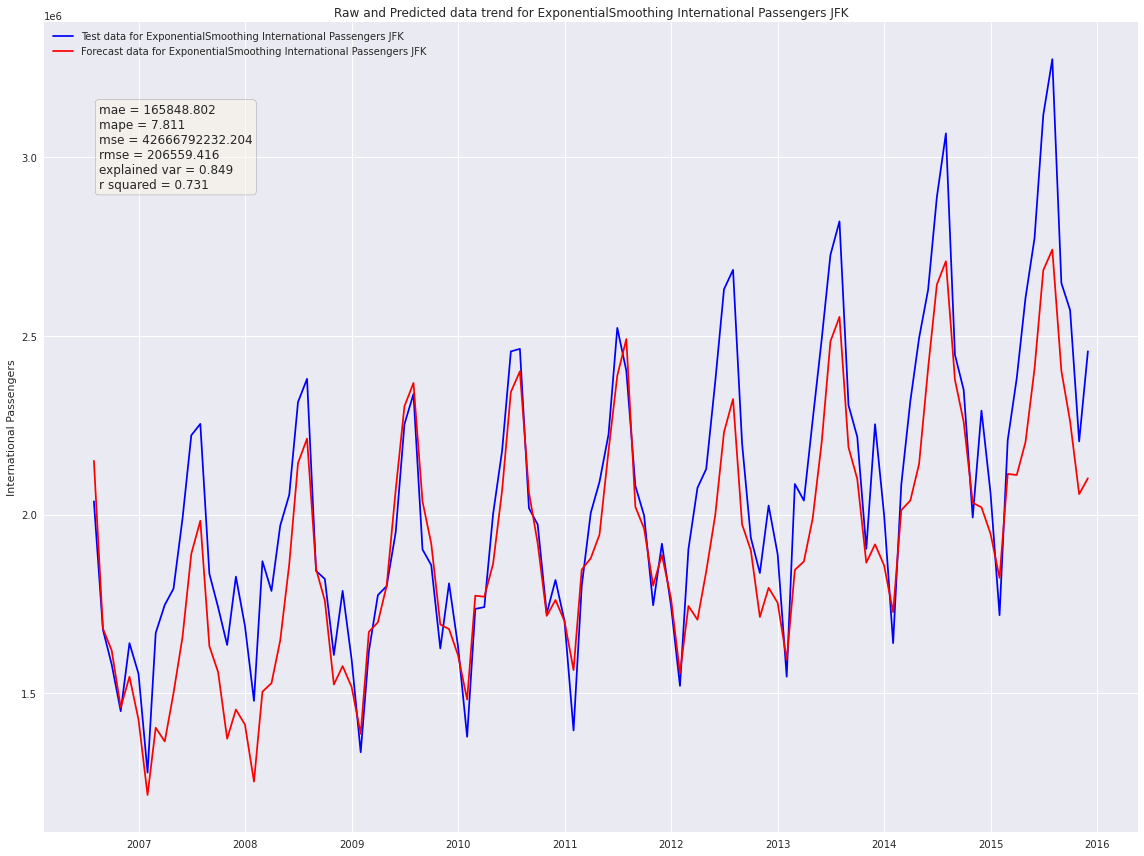

In [19]:
""" Function wrapping around a Holt-Winters Exponential Smoothing algorithm, its fitting of a model, and forecasting
:param train: The training time series data to train the model upon
:param test: The holdout validation test data (purely for getting the date index values for the forecasting space)
:param trend: The type of the trend component (one of: 'add'(additive) or 'mul'(multiplicative))
:param seasonal: The type of seasonal component (one of: 'add'(additive) or 'mul'(multiplicative))
:param periods: The number of periods within a full seasonal cycle (e.g. 12 for months if monthly periodicity)
:param dampening: Boolean switch of whether the trend component of the series should be damped or not.
:param smooth_slope: Holt's trend beta value
:param damping_slope: phi value of the damping method for the trend slope.
"""
def exp_smoothing(train, test, trend, seasonal, periods, dampening, smooth_slope, damping_slope):
    output = {}
    exp_smoothing_model = ExponentialSmoothing(train,
                                               trend=trend,
                                               seasonal=seasonal,
                                               seasonal_periods=periods,
                                               damped=dampening
                                              )
    # see note 1 below in next cell
    exp_fit = exp_smoothing_model.fit(smoothing_level=0.9,
                                      smoothing_seasonal=0.2,
                                      smoothing_slope=smooth_slope,
                                      damping_slope=damping_slope,
                                      use_brute=True,
                                      use_boxcox=False,
                                      use_basinhopping=True,
                                      remove_bias=True
                                     )
    forecast = exp_fit.predict(train.index[-1], test.index[-1])
    output['model'] = exp_fit
    output['forecast'] = forecast[1:]
    return output

jfk = get_airport_data('JFK', DATA_PATH)
jfk = apply_index_freq(jfk, 'MS')
train, test = generate_splits(jfk, '2006-07-08')
prediction = exp_smoothing(train['Domestic Passengers'], 
                           test['Domestic Passengers'], 
                           'add', 
                           'add', 
                           48, 
                           True, 
                           0.9, 
                           0.5
                          )
prediction_intl = exp_smoothing(train['International Passengers'], 
                                test['International Passengers'], 
                                'add', 
                                'add', 
                                60, 
                                True, 
                                0.1, 
                                1.0
                               )
exp_smooth_pred = plot_predictions(test['Domestic Passengers'], 
                                   prediction['forecast'],
                                   "ExponentialSmoothing Domestic Passengers JFK",
                                   "Domestic Passengers",
                                   "exp_smooth_dom.svg"
                                  )
exp_smooth_pred_intl = plot_predictions(test['International Passengers'], 
                                   prediction_intl['forecast'],
                                   "ExponentialSmoothing International Passengers JFK",
                                   "International Passengers",
                                   "exp_smooth_intl.svg"
                                  )


note 1: Some packages have 'additional' hyperparameters that are part of the .fit() method on the model's API main class. It's always best to look fully through the API documentation for not only the main class but also in the API documentation for the .fit() method of the class. If there are specific additional settings that are defined within this method call, it's best to either record them as placeholders for tuning during the MVP phase (as we have done above with the hard-coded values of:
- smoothing_level
- smoothing_seasonal
- use_brute
- use_boxcox
- use_basinhopping
- remove_bias